In [ ]:
#!pip install opensmile
#!pip install librosa
#!pip install pydub
#!pip install AudioSegment
#!pip install ffmpeg 
#!pip install sns

In [2]:

import librosa
import soundfile as sf
import opensmile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

#SCORE AL AUDIO
def audio_quality_score(y, sr):
    score = 100
    detalles = {}

    # 1️⃣ RMS (volumen promedio de la señal)
    # Calcula la energía media del audio.
    # Un RMS muy bajo indica audio débil o silencioso.
    # Un RMS muy alto indica audio saturado o mal normalizado.
    rms = np.sqrt(np.mean(y**2))
    detalles["rms"] = rms

    # Penaliza si el volumen está fuera del rango saludable para voz
    # Rango recomendado: 0.05 – 0.15
    if rms < 0.05 or rms > 0.15:
        score -= 30


    # 2️⃣ Clipping (saturación de la señal)
    # Detecta si la señal alcanza o supera ±1.0,
    # lo que indica recorte digital (distorsión).
    clipping = np.any(np.abs(y) >= 1.0)
    detalles["clipping"] = clipping

    # El clipping es muy dañino para jitter, shimmer y HNR,
    # por eso se penaliza fuertemente.
    if clipping:
        score -= 40

    # 3️⃣ Duración útil del audio
    # Calcula la duración total en segundos.
    # Audios muy cortos no permiten estimar bien
    # características acústicas estables.
    duration = len(y) / sr
    detalles["duracion"] = duration

    # Penaliza audios demasiado cortos (< 2 segundos)
    # porque generan medidas inestables en openSMILE.
    if duration < 2.0:
        score -= 20

    # 4️⃣ Pico robusto (percentil 95)
    # Mide la amplitud típica alta ignorando picos extremos.
    # Es más robusto que usar el máximo absoluto.
    peak95 = np.percentile(np.abs(y), 95)
    detalles["peak95"] = peak95

    # Si el pico típico supera 1.0, la señal está
    # mal escalada o muy cerca del clipping.
    if peak95 > 1.0:
        score -= 10


    # Asegurar que el score final esté entre 0 y 100
    # Evita valores negativos tras aplicar penalizaciones.
    score = max(0, score)


    # Etiqueta final
    if score >= 80:
        calidad = "Excelente"
    elif score >= 60:
        calidad = "Usable"
    else:
        calidad = "Mala"

    return score, calidad, detalles



y, sr = librosa.load("./audio_no_dement/Tinaturner_1.wav", sr=16000, mono=True)

score, calidad, detalles = audio_quality_score(y, sr)

print("Score:", score)
print("Calidad:", calidad)
print("Detalles:", detalles)

Score: 70
Calidad: Usable
Detalles: {'rms': np.float32(0.038427833), 'clipping': np.False_, 'duracion': 18.0, 'peak95': np.float32(0.083943754)}


In [5]:
#Normalizacion del audio A 16K

audio_movil="salida.wav"
salida_normalizada="salida_normalizado.wav"
# Cargar audio
#y, sr = librosa.load("./audio_dement/TeresaGorman_10.wav", sr=16000, mono=True)
y, sr = librosa.load(audio_movil, sr=16000, mono=True)
# Normalización RMS (volumen razonable)
rms = np.sqrt(np.mean(y**2))
y = y / rms * 0.1   # 0.1 ≈ nivel cómodo para voz

# Guardar audio normalizado
sf.write(salida_normalizada, y, 16000)


### ¿Para qué sirve eGeMAPS?

eGeMAPS se creó para extraer solo las variables más informativas y robustas, evitando miles de parámetros redundantes. Se usa mucho en:
Reconocimiento de emociones
Evaluación de calidad vocal
Estudios clínicos (Parkinson, depresión, disfonía)
Análisis de prosodia y fluidez
Comparación entre estudios (reproducibilidad científica)


¿Qué incluye eGeMAPS?

eGeMAPS contiene 88 variables finales, derivadas de descriptores de bajo nivel (LLDs) como:

🔊 Prosodia
F0 (media, rango, percentiles)
Loudness
Duración de segmentos sonoros y silencios

🎙️ Calidad de voz
Jitter
Shimmer
HNR
Harmonic differences (H1–H2)

🎛️ Espectrales
Alpha ratio
Hammarberg index
Spectral slope
Formantes (F1–F3)

⏱️ Temporal / fluidez
Número y duración de pausas
Ratio de habla vs silencio

In [6]:

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

features = smile.process_file(salida_normalizada)


variables_acusticas = {
    "F0semitoneFrom27.5Hz_sma3nz_amean - Tono medio de la voz " : features['F0semitoneFrom27.5Hz_sma3nz_amean'].iloc[0],
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm - indica cambios de entonación y expresividad" : features['F0semitoneFrom27.5Hz_sma3nz_stddevNorm'].iloc[0],
    "loudness_sma3_amean - Intensidad percibida media de la voz" : features['loudness_sma3_amean'].iloc[0],
    "loudness_sma3_stddevNorm - cambios de volumen" : features['loudness_sma3_stddevNorm'].iloc[0],
    "jitterLocal_sma3nz_amean -  irregularidad en la vibración de las cuerdas vocales" : features['jitterLocal_sma3nz_amean'].iloc[0],
    "jitterLocal_sma3nz_stddevNorm -  cambios en la estabilidad del tono a lo largo del tiempo" : features['jitterLocal_sma3nz_stddevNorm'].iloc[0],
    "shimmerLocaldB_sma3nz_amean - aspereza o fatiga vocal" : features['shimmerLocaldB_sma3nz_amean'].iloc[0],
    "shimmerLocaldB_sma3nz_stddevNorm - fluctuaciones en la amplitud de la voz" : features['shimmerLocaldB_sma3nz_stddevNorm'].iloc[0],
    "HNRdBACF_sma3nz_amean - Relación armónicos–ruido (HNR); claridad de la voz frente a ronquera" : features['HNRdBACF_sma3nz_amean'].iloc[0],
    "HNRdBACF_sma3nz_stddevNorm - Variabilidad del HNR; cambios en la calidad vocal" : features['HNRdBACF_sma3nz_stddevNorm'].iloc[0],
    "alphaRatioV_sma3nz_amean - Relación de energía entre bandas graves y agudas" : features['alphaRatioV_sma3nz_amean'].iloc[0],
    "alphaRatioV_sma3nz_stddevNorm - cambios en el timbre" : features['alphaRatioV_sma3nz_stddevNorm'].iloc[0],
    "hammarbergIndexV_sma3nz_amean - Balance de energía espectral entre frecuencias bajas y altas; proyección o tensión vocal" : features['hammarbergIndexV_sma3nz_amean'].iloc[0],
    "hammarbergIndexV_sma3nz_stddevNorm - Variabilidad del balance espectral; cambios en la proyección vocal" : features['hammarbergIndexV_sma3nz_stddevNorm'].iloc[0],
    "slopeV0-500_sma3nz_amean - Pendiente espectral entre 0 y 500 Hz; características de la fuente glótica" : features['slopeV0-500_sma3nz_amean'].iloc[0],
    "slopeV500-1500_sma3nz_amean - Pendiente espectral entre 500 y 1500 Hz; configuración del tracto vocal" : features['slopeV500-1500_sma3nz_amean'].iloc[0]
}
pd.Series(variables_acusticas)


def grafico(ymin,ymax,ylabel,tittle0):
    plt.figure(figsize=(3, 4))
    plt.axhspan(ymin, ymax, alpha=0.3, label="Rango de referencia")

    # Punto del valor observado
    sns.scatterplot(x=[0], y=features[ylabel].iloc[0], s=50, label="Valor observado")

    # Ajustes
    plt.ylim(ymin - abs(ymin)*0.3, ymax + abs(ymax)*0.3)
    plt.xticks([])
    plt.ylabel(ylabel)
    plt.title(tittle0)
    plt.legend()

    plt.tight_layout()
    plt.show()
#variables_acusticas

In [ ]:

rangos_referencia = {
    "F0semitoneFrom27.5Hz_sma3nz_amean": (20, 40),
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm": (0.05, 0.30),
    "loudness_sma3_amean": (0.2, 1.5),
    "loudness_sma3_stddevNorm": (0.2, 1.0),
    "jitterLocal_sma3nz_amean": (0.002, 0.03),
    "jitterLocal_sma3nz_stddevNorm": (0.3, 2.0),
    "shimmerLocaldB_sma3nz_amean": (0.2, 2.5),
    "shimmerLocaldB_sma3nz_stddevNorm": (0.3, 2.0),
    "HNRdBACF_sma3nz_amean": (5, 30),
    "HNRdBACF_sma3nz_stddevNorm": (0.2, 1.5),
    "alphaRatioV_sma3nz_amean": (-30, -5),
    "alphaRatioV_sma3nz_stddevNorm": (-1.0, 1.0),
    "hammarbergIndexV_sma3nz_amean": (10, 40),
    "hammarbergIndexV_sma3nz_stddevNorm": (0.1, 1.0),
    "slopeV0-500_sma3nz_amean": (-0.1, 0.2),
    "slopeV500-1500_sma3nz_amean": (-0.2, 0.1)
}


### Tono medio de la voz

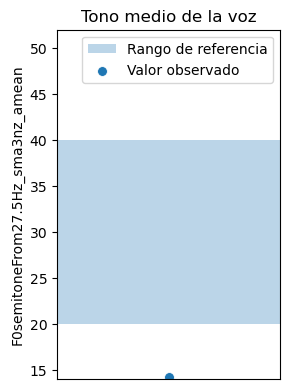

In [7]:
grafico(ymin=20,ymax=40,ylabel="F0semitoneFrom27.5Hz_sma3nz_amean",tittle0="Tono medio de la voz")

### Indica cambios de entonación y expresividad 

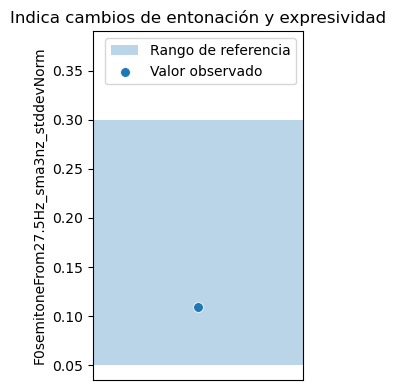

In [8]:
                                       
grafico(ymin=0.05,ymax=0.30,ylabel="F0semitoneFrom27.5Hz_sma3nz_stddevNorm",tittle0="Indica cambios de entonación y expresividad")

### Intensidad percibida media de la voz

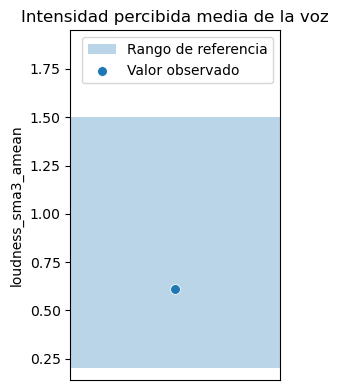

In [9]:
grafico(ymin=0.2,ymax=1.5,ylabel="loudness_sma3_amean",tittle0="Intensidad percibida media de la voz")

### Cambios de volumen

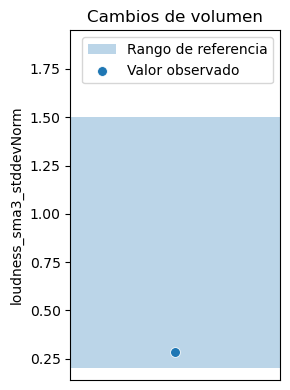

In [10]:
grafico(ymin=0.2,ymax=1.5,ylabel="loudness_sma3_stddevNorm",tittle0="Cambios de volumen")

### Irregularidad en la vibración de las cuerdas vocales 

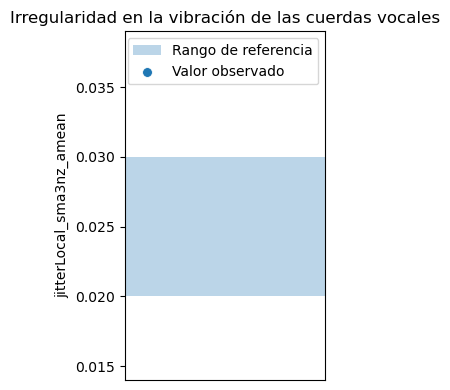

In [11]:
grafico(ymin=0.02,ymax=0.03,ylabel="jitterLocal_sma3nz_amean",tittle0="Irregularidad en la vibración de las cuerdas vocales")

### Cambios en la estabilidad del tono a lo largo del tiempo

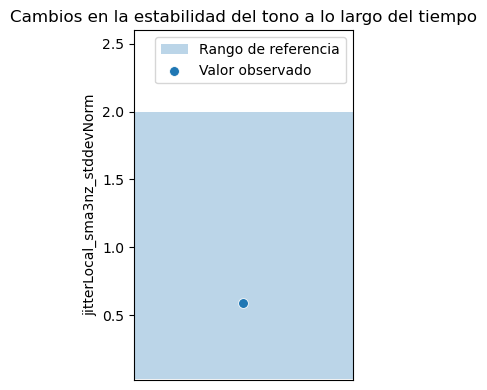

In [12]:
grafico(ymin=0.03,ymax=2.0,ylabel="jitterLocal_sma3nz_stddevNorm",tittle0="Cambios en la estabilidad del tono a lo largo del tiempo")

### Aspereza o fatiga vocal

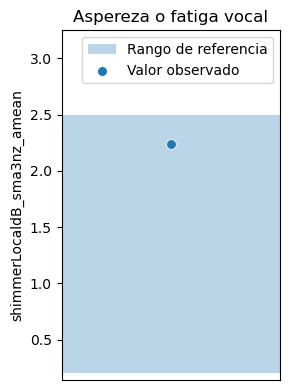

In [13]:
grafico(ymin=0.2,ymax=2.5,ylabel="shimmerLocaldB_sma3nz_amean",tittle0="Aspereza o fatiga vocal")

### Fluctuaciones en la amplitud de la voz

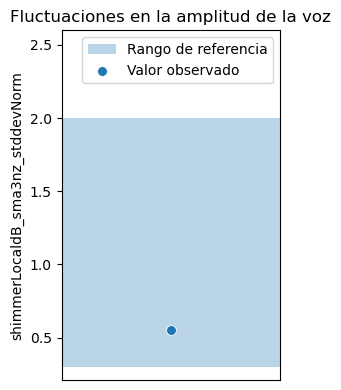

In [14]:
grafico(ymin=0.3,ymax=2.0,ylabel="shimmerLocaldB_sma3nz_stddevNorm",tittle0="Fluctuaciones en la amplitud de la voz")

### Claridad de la voz frente a ronquera

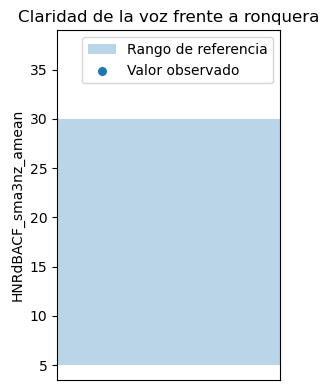

In [15]:
grafico(ymin=5,ymax=30,ylabel="HNRdBACF_sma3nz_amean",tittle0="Claridad de la voz frente a ronquera")

### Cambios en la calidad vocal

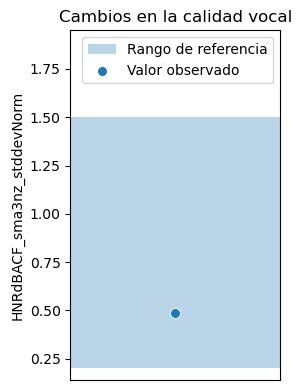

In [20]:
grafico(ymin=0.2,ymax=1.5,ylabel="HNRdBACF_sma3nz_stddevNorm",tittle0="Cambios en la calidad vocal")

### Relación de energía entre bandas graves y agudas

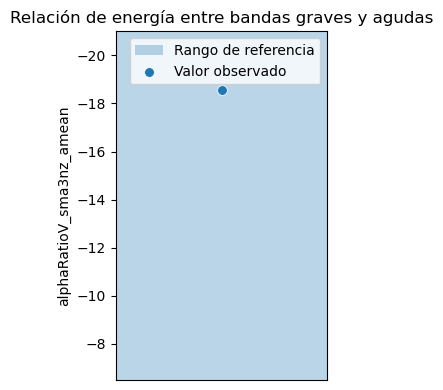

In [22]:
grafico(ymin=-5,ymax=-30,ylabel="alphaRatioV_sma3nz_amean",tittle0="Relación de energía entre bandas graves y agudas")

### Cambios en el timbre

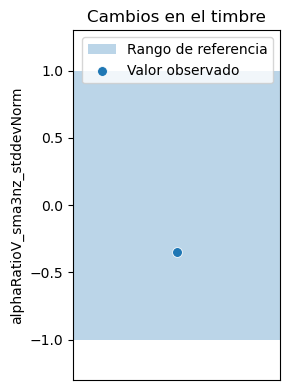

In [23]:
grafico(ymin=-1.0,ymax=1.0,ylabel="alphaRatioV_sma3nz_stddevNorm",tittle0="Cambios en el timbre")

### Balance de energía espectral entre frecuencias bajas y altas

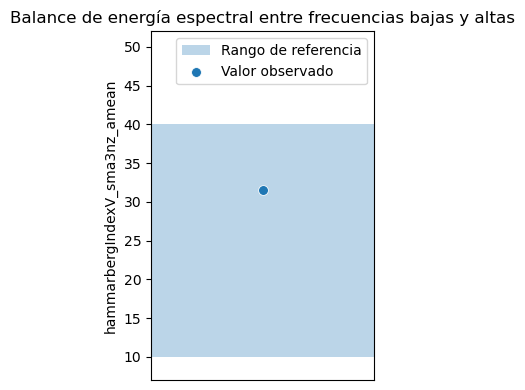

In [24]:
grafico(ymin=10,ymax=40,ylabel="hammarbergIndexV_sma3nz_amean",tittle0="Balance de energía espectral entre frecuencias bajas y altas")

### Variabilidad del balance espectral

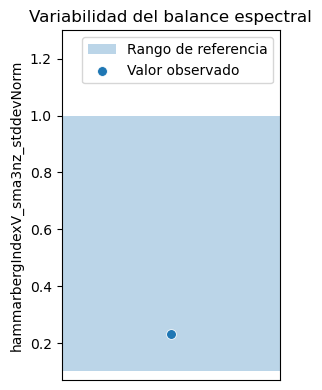

In [25]:
grafico(ymin=0.1,ymax=1.0,ylabel="hammarbergIndexV_sma3nz_stddevNorm",tittle0="Variabilidad del balance espectral")

### Pendiente espectral entre 0 y 500 Hz - características de la fuente glótica 

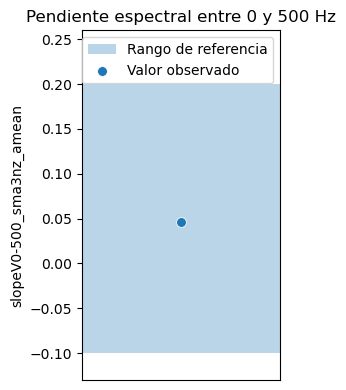

In [27]:
grafico(ymin=-0.1,ymax=0.2,ylabel="slopeV0-500_sma3nz_amean",tittle0="Pendiente espectral entre 0 y 500 Hz")

### Pendiente espectral entre 500 y 1500 Hz - configuración del tracto vocal

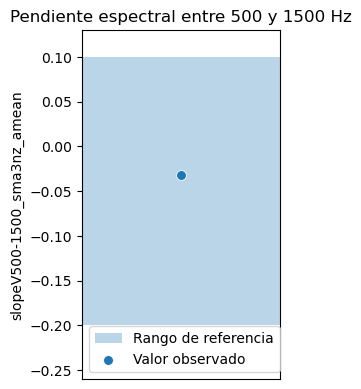

In [35]:
grafico(ymin=-0.2,ymax=0.1,ylabel="slopeV500-1500_sma3nz_amean",tittle0="Pendiente espectral entre 500 y 1500 Hz")